# Importando Bibliotecas

In [270]:
# Para manipulação de dados
import pandas as pd
import numpy as np
import json

# Para carregamento dos temas
from functools import lru_cache

# Para visualização de dados
import matplotlib.pyplot as plt
import matplotlib.cm as cm # transformar valores numéricos em cores - colormaps (palleta de cores)
import matplotlib.colors as mcolors # manipulação de cores, conversões entre formatos (hex, RGB, etc.)
import matplotlib.ticker as mticker # formatar e controlar os valores dos eixos

# Generalidades
from datetime import datetime
import math
import re
import unicodedata
import os

# Aplica as configurações de fonte para os gráficos
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

## Definindo caminho base

In [271]:
# Define caminho base como o diretório atual (adaptado para notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..')) # ou defina manualmente se necessário

# Carregando os dados

In [272]:
# Carregar os dados do arquivo csv em um objeto Pandas DataFrame
caminho_processed = os.path.join(BASE_DIR, 'dados', 'processed', 'imoveis_com_amenidades.csv')
df = pd.read_csv(f"{caminho_processed}")

# Exibir as primeiras 5 linhas do DataFrame
df.head()

,bairro,area,quartos,banheiros,vagas,hospital,gas_station,school,supermarket,restaurant,pharmacy,preco
0,Vila Passos,70,2.0,1.0,1.0,1,1,1,1,1,1,260000
1,Parque Mondesir,120,4.0,1.0,2.0,1,1,1,1,1,0,350000
2,Cidade Industrial,137,3.0,1.0,2.0,1,1,1,1,1,1,300000
3,Santo Antônio,142,3.0,1.0,3.0,1,0,1,1,1,1,370000
4,Vila Brito,300,3.0,5.0,3.0,1,1,1,1,1,0,499000


# Descrição dos dados

## Estrutura

In [273]:
# Verificar a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bairro       832 non-null    object 
 1   area         832 non-null    int64  
 2   quartos      559 non-null    float64
 3   banheiros    571 non-null    float64
 4   vagas        462 non-null    float64
 5   hospital     832 non-null    int64  
 6   gas_station  832 non-null    int64  
 7   school       832 non-null    int64  
 8   supermarket  832 non-null    int64  
 9   restaurant   832 non-null    int64  
 10  pharmacy     832 non-null    int64  
 11  preco        832 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 78.1+ KB


## Preenchendo valores nulos e alterando schema do dataframe

In [274]:
# Quando temos um imóvel do tipo terreno, não há quartos, vagas ou banheiros, etc. L
# Logo é importante preencher esses valores com 0.

cols = ['quartos', 'banheiros', 'vagas', 'hospital', 'gas_station','school', 'supermarket', 'restaurant', 'pharmacy']

# Preenchendo os valores NA com 0
df[cols] = df[cols].fillna(0).astype(int)

# Temos um imóvel na Área Rural que tem área igual a Zero.
# Vamos preencher esse valor com a Mediana da área nesse bairro
# Filtra o DataFrame para pegar as linhas do bairro "Área Rural de Lorena"
rural = df[df['bairro']=='Área Rural de Lorena']

# Calcula a mediana ignorando valores zero na coluna 'area'
mediana = rural[rural['area'] != 0]['area'].median()

# Preenche área 0 com a mediana nos imóveis da Área Rural de Lorena
df.loc[
    (df['bairro'] == 'Área Rural de Lorena') & (df['area'] == 0), # condições para localizar os valores
    'area' # na coluna área
    ] = int(mediana) # definindo esses valores como a mediana

# DataFrame após preenchido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   bairro       832 non-null    object
 1   area         832 non-null    int64 
 2   quartos      832 non-null    int64 
 3   banheiros    832 non-null    int64 
 4   vagas        832 non-null    int64 
 5   hospital     832 non-null    int64 
 6   gas_station  832 non-null    int64 
 7   school       832 non-null    int64 
 8   supermarket  832 non-null    int64 
 9   restaurant   832 non-null    int64 
 10  pharmacy     832 non-null    int64 
 11  preco        832 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 78.1+ KB


# Estatísticas

In [275]:
# Resumo estatístico das variáveis numéricas do DataFrame.
df.describe().map('{:,.0f}'.format)

,area,quartos,banheiros,vagas,hospital,gas_station,school,supermarket,restaurant,pharmacy,preco
count,832,832,832,832,832,832,832,832,832,832,832
mean,"477,496",2,1,2,1,1,1,1,1,1,"1,731,923"
std,"12,586,527",2,2,5,0,0,0,0,0,0,"5,385,657"
min,1,0,0,0,0,0,0,0,0,0,"75,000"
25%,130,0,0,0,1,1,1,1,1,1,"299,000"
50%,235,2,1,1,1,1,1,1,1,1,"468,000"
75%,750,3,2,2,1,1,1,1,1,1,"960,000"
max,"363,000,000",50,50,80,1,1,1,1,1,1,"78,000,000"


## **Funções utilitárias para gráficos**

In [276]:
# Carrega e configura os temas
@lru_cache(maxsize=32)
def get_tema(tema, linewidth=1.5, alpha=0.8, hatch='', tamanho_titulo_geral=18, tamanho_titulo_ax=13, tamanho_fonte=12):
    caminho_tema = os.path.join(BASE_DIR, 'utils', 'eda_themes.json')
    with open(caminho_tema, 'r', encoding='utf-8') as f:
        temas = json.load(f)
    if tema not in temas:
        raise ValueError(f"Tema '{tema}' não encontrado.")
    tema_config = temas[tema].copy()
    tema_config['linewidth'] = linewidth
    tema_config['alpha'] = alpha
    tema_config['hatch'] = hatch
    tema_config['tamanho_titulo_geral'] = tamanho_titulo_geral
    tema_config['tamanho_fonte'] = tamanho_fonte
    tema_config['tamanho_titulo_ax'] = tamanho_titulo_ax
    
    return tema_config

temas_disponiveis = [
    "arctic", "autumn", "autumn_gold", "base", "binary", "candy", "cool_mint",
    "coral", "cyberpunk", "dark", "desert", "earth_tones", "electric", "emerald",
    "forest", "galaxy", "grayscale", "ice", "lava", "light", "matrix", "midnight",
    "neon", "nordic", "ocean", "ocean_deep", "pastel", "plasma", "rainbow_bright",
    "retro", "solarized", "spring_bloom", "spring_bloom", "summer_heat",
    "sunset", "sunset_fire", "toxic", "turbo", "vibrant", "vintage", "volcano"
]


temas_carregados = {nome: get_tema(nome) for nome in temas_disponiveis}

# Aplica estilos aos elementos dos gráficos
def formatar_elementos(elementos, **kwargs):
    """Aplica estilos a elementos de gráficos se tiverem os atributos correspondentes."""
    atributos = {
        "set_facecolor": kwargs.get("facecolor"),
        "set_edgecolor": kwargs.get("edgecolor"),
        "set_linewidth": kwargs.get("linewidth"),
        "set_alpha": kwargs.get("alpha"),
        "set_hatch": kwargs.get("hatch"),
        "set_color": kwargs.get("color")
    }
    
    for el in elementos:
        for attr, value in atributos.items():
            if hasattr(el, attr) and value is not None:
                getattr(el, attr)(value)

# Função para formatar dinamicamente os eixos x e y
def formatar_eixo(ax, eixo, rotacao=None, label='', ha='center', tamanho_fonte=None):
    """Formata um eixo do gráfico com rótulos, rotação e formatação."""
    # Define e formata o rótulo do eixo
    getattr(ax, f'set_{eixo}label')(label)
    label_obj = ax.xaxis.label if eixo == 'x' else ax.yaxis.label
    label_obj.set_fontsize(tamanho_fonte)

    # Rotaciona os rótulos se necessário
    if rotacao is not None:
        ticklabels = ax.get_xticklabels() if eixo == 'x' else ax.get_yticklabels()
        plt.setp(ticklabels, rotation=rotacao, ha=ha)

    # Altera o tamanho da fonte dos rótulos
    ax.tick_params(axis=eixo, labelsize=tamanho_fonte) 
    
    # Tratamento especial para eixo y
    if eixo == 'y':
        if not label:
            # Oculta o eixo y se o label estiver vazio
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            # Formata valores numéricos no eixo y
            yticks = ax.get_yticks()
            ylabels = [
                f'{y/1e6:.1f}M'.replace('.', ',') if y >= 1e6 else
                f'{y/1e3:.1f}k'.replace('.', ',') if y >= 1e3 else
                f'{y:.0f}'
                for y in yticks
            ]
            ax.set_yticks(yticks)
            ax.set_yticklabels(ylabels)

def formatar_histograma(hist, tema, cor):
    """Formata um histograma aplicando cores e estilos."""
    _, _, patches = hist
    formatar_elementos(patches, facecolor=cor, edgecolor=tema['edgecolor'], 
                      linewidth=tema['linewidth'], alpha=tema['alpha'], hatch=tema['hatch'])

def calcular_luminosidade(cor):
    """Calcula a luminosidade de uma cor RGB."""
    r, g, b = cor[:3]  # ignora alpha se presente
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

def definir_cores(valores, tema):
    """Gera cores para barras e determina cores de texto apropriadas."""
    cmap = plt.get_cmap(tema['colormap'])
    
    # Gera cores distribuídas do colormap
    bar_colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(valores))][::-1]
    
    # Determina cores de texto baseadas na luminosidade
    label_colors = ['white' if calcular_luminosidade(cor) < 0.5 else 'black' for cor in bar_colors]
    
    return bar_colors, label_colors

def smart_bar_label_customization(fig, ax, bars, valores_formatados, label_colors, tamanho_fonte, tema):
    """Posiciona rótulos em barras de forma inteligente baseado em suas dimensões."""
    cor_texto = tema.get("textcolor", "black")
    
    # Pré-calcula dimensões para todas as barras
    dimensoes = []
    for bar, valor in zip(bars, valores_formatados):
        # Texto temporário para medir largura
        temp_text = ax.text(0, 0, valor)
        fig.canvas.draw()
        largura_rotulo = temp_text.get_window_extent().width
        temp_text.remove()
        
        # Calcula dimensões da barra
        _, y0 = ax.transData.transform((0, 0))
        _, y1 = ax.transData.transform((0, bar.get_height()))
        altura_em_px = abs(y1 - y0) * 0.80
        
        x0, _ = ax.transData.transform((0, 0))
        x1, _ = ax.transData.transform((bar.get_width(), 0))
        largura_em_px = abs(x1 - x0)
        
        dimensoes.append((largura_rotulo, altura_em_px, largura_em_px))
    
    # Aplica rótulos com posicionamento otimizado
    for i, (bar, valor, cor, (largura_rotulo, altura_em_px, largura_em_px)) in enumerate(
            zip(bars, valores_formatados, label_colors, dimensoes)):
        
        x_center = bar.get_x() + bar.get_width() / 2
        offset = bar.get_height() * 0.1
        
        # Escolhe o melhor posicionamento baseado nas dimensões
        if largura_rotulo > altura_em_px:
            ax.text(x_center, bar.get_height() + offset, valor, 
                   color=cor_texto, fontsize=tamanho_fonte,
                   ha='left', va='bottom', rotation=45)
        elif largura_rotulo < largura_em_px:
            ax.text(x_center, bar.get_height(), valor,
                   color=cor_texto, fontsize=tamanho_fonte,
                   ha='center', va='bottom', rotation=0)
        elif largura_rotulo < altura_em_px:
            ax.text(x_center, bar.get_height() / 2, valor,
                   color=cor, fontsize=tamanho_fonte,
                   ha='center', va='center', rotation=90)
        else:
            ax.text(x_center, bar.get_height() + offset, valor,
                   color=cor_texto, fontsize=tamanho_fonte,
                   ha='center', va='bottom', rotation=0)

def formatar_barras(ax, valores, tema, fig=None, exibir_rotulos=True):
    """Formata barras com cores e adiciona rótulos."""
    bar_colors, label_color = definir_cores(valores, tema)
    
    # Aplica formatação a todas as barras
    for barra, cor in zip(ax.patches, bar_colors):
        formatar_elementos([barra], facecolor=cor, edgecolor=tema.get('edgecolor', 'black'),
                          linewidth=tema.get('linewidth', 1.5), alpha=tema.get('alpha', 1.0),
                          hatch=tema.get('hatch', None))

    # Adiciona rótulos se necessário
    if exibir_rotulos and fig is not None:
        valores_formatados = [f"{v:.0f}" for v in valores]
        smart_bar_label_customization(fig, ax, ax.patches, valores_formatados, label_color, tema.get('tamanho_fonte', 13), tema)

def formatar_boxplot(box, tema, cor):
    """Formata elementos de um boxplot."""
    formatar_elementos(box['boxes'], facecolor=cor, edgecolor=tema['edgecolor'],
                      linewidth=tema['linewidth'], alpha=tema['alpha'], hatch=tema['hatch'])
    formatar_elementos(box['whiskers'], color=tema['color'], linewidth=tema['linewidth'])
    formatar_elementos(box['caps'], color=tema['color'], linewidth=tema['linewidth'])
    formatar_elementos(box['medians'], color=tema['color'], linewidth=tema['linewidth'])

def remover_outliers(df, limites=None):
    """
    Remove outliers com base em limites fixos para colunas específicas.
    
    Args:
        df: DataFrame a ser filtrado
        limites: Dicionário opcional com limites personalizados
        
    Returns:
        DataFrame sem outliers
    """
    # Limites padrão se não fornecidos
    if limites is None:
        limites = {
            "area": 3000,       # área do terreno
            "preco": 3000000,   # preco do imóvel/terreno
            "quartos": 10,      # número de quartos
            "banheiros": 10,    # número de banheiros
            "vagas": 10         # número de vagas
        }

    # Cria máscara combinada para todas as colunas
    mask = np.ones(len(df), dtype=bool)
    for col, limite in limites.items():
        if col in df.columns:
            mask &= (df[col].isna()) | (df[col] < limite)
    
    return df[mask].copy()

def remover_outliers_quantis(df, colunas=None, inferior=0.01, superior=0.99):
    """
    Remove outliers com base em quantis para colunas numéricas.
    
    Args:
        df: DataFrame a ser filtrado
        colunas: Lista de colunas para filtrar (se None, usa todas numéricas)
        inferior: Quantil inferior (default: 0.01)
        superior: Quantil superior (default: 0.99)
        
    Returns:
        DataFrame sem outliers
    """
    if colunas is None:
        colunas = df.select_dtypes(include=['number']).columns
    
    # Filtra apenas colunas existentes
    colunas = [col for col in colunas if col in df.columns]
    
    # Cria cópia inicial
    df_filtrado = df.copy()
    
    # Cria máscara combinada para todas as colunas
    mask = np.ones(len(df), dtype=bool)
    for col in colunas:
        q_inf = df[col].quantile(inferior)
        q_sup = df[col].quantile(superior)
        col_mask = (df[col].isna()) | ((df[col] >= q_inf) & (df[col] <= q_sup))
        mask &= col_mask
    
    return df[mask].copy()

def obter_outliers(dfCol):
    """
    Identifica outliers em uma série usando o método IQR.
    
    Args:
        dfCol: Série pandas com dados numéricos
        
    Returns:
        Série contendo apenas os outliers
    """
    q1, q3 = dfCol.quantile([0.25, 0.75])
    iqr = q3 - q1
    limites = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return dfCol[(dfCol < limites[0]) | (dfCol > limites[1])]

def desenhar_outliers(outliers, ax, cmap, tema):
    """
    Desenha outliers em um gráfico.
    
    Args:
        outliers: Série com outliers
        ax: Eixo do matplotlib
        cmap: Colormap
        tema: Dicionário com configurações de tema
    """
    if outliers.empty:
        return
        
    # Usa o colormap do tema
    cmap2 = plt.get_cmap(tema.get("colormap"))
    
    # Normaliza valores para coloração
    std = outliers.std()
    if std > 0:  # Evita divisão por zero
        norm2 = (outliers - outliers.mean()) / std
        colors2 = cmap2(norm2.to_numpy())
    else:
        colors2 = [cmap2(0.5)] * len(outliers)
        
    # Desenha os outliers
    ax.scatter(outliers, np.full(len(outliers), 1),
              color=colors2, s=40, edgecolor='black', linewidth=1)

def formatar_matriz_correlacao(ax, correlacao, tema):
    """
    Formata uma matriz de correlação com rótulos e valores.
    
    Args:
        ax: Eixo do matplotlib
        correlacao: DataFrame de correlação
        tema: Dicionário com configurações de tema
    """
    labels = correlacao.columns
    ticks = np.arange(len(labels))
    text_color = tema.get("textcolor", "black")
    
    # Configura rótulos dos eixos
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=tema.get('tamanho_fonte', 12), color=text_color)
    ax.set_yticklabels(labels, fontsize=tema.get('tamanho_fonte', 12), color=text_color)

    # Adiciona valores de correlação como texto
    for i, linha in enumerate(correlacao.values):
        for j, valor in enumerate(linha):
            cor = 'white' if abs(valor) > 0.5 else 'black'
            ax.text(j, i, f"{valor:.2f}", ha='center', va='center', color=cor, fontsize=tema.get('tamanho_fonte', 12))

    # Configura parâmetros de exibição
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

def formatar_ax_fig(fig, axes, tema):
    """
    Aplica formatação a figura e eixos com base no tema.
    
    Args:
        fig: Figura do matplotlib
        axes: Lista de eixos
        tema: Dicionário com configurações de tema
    """
    # Formata o fundo da figura
    if 'fundofig' in tema:
        fig.patch.set_facecolor(tema['fundofig'])
    
    # Extrai configurações comuns
    text_color = tema.get('textcolor')
    grid_props = {
        'visible': tema.get('grid', True),
        'color': tema.get('grid_color', 'gray'),
        'linestyle': tema.get('grid_linestyle', '--'),
        'alpha': tema.get('grid_alpha', 0.3)
    }
    
    # Formata cada eixo
    for ax in axes:
        if 'fundoax' in tema:
            ax.set_facecolor(tema['fundoax'])
            
        # Aplica cor de texto
        if text_color:
            ax.title.set_color(text_color)
            ax.xaxis.label.set_color(text_color)
            ax.yaxis.label.set_color(text_color)
            ax.tick_params(colors=text_color)
            
        # Configura grade
        if grid_props['visible']:
            ax.grid(True, color=grid_props['color'], 
                   linestyle=grid_props['linestyle'], 
                   alpha=grid_props['alpha'])
                   
        # Configura bordas
        if 'spinecolor' in tema:
            for spine in ax.spines.values():
                spine.set_edgecolor(tema['spinecolor'])

def get_auto_subplot_dim(c):
    """
    Calcula dimensões automáticas para subplots.
    
    Args:
        c: Número de gráficos
        
    Returns:
        Tupla (nrows, ncols) com número de linhas e colunas
    """
    ncols = math.ceil(math.sqrt(c))
    nrows = math.ceil(c / ncols)
    return nrows, ncols

def criar_grafico(ax, df, col, tipo, cor, tema, fig=None, titulo=None):
    """
    Cria um gráfico específico em um eixo.
    
    Args:
        ax: Eixo para desenhar o gráfico
        df: DataFrame com os dados
        col: Coluna ou lista de colunas para plotar
        tipo: Tipo de gráfico ('histograma', 'boxplot', 'barras', 'correlacao')
        cor: Cor para o gráfico
        tema: Dicionário com configurações de tema
        fig: Figura do matplotlib (necessário para alguns tipos)
        titulo: Título opcional para o gráfico
    """
    # Define título padrão se não fornecido
    if titulo is None:
        if tipo == "correlacao":
            titulo = "Matriz de Correlação"
        elif isinstance(col, list) and len(col) >= 2:
            titulo = f"{col[1].capitalize().replace('_', ' de ')} por {col[0]}"
        else:
            titulo = f"{col} - {tipo}"
    
    # Configura o gráfico com base no tipo
    if tipo == "histograma":
        hist = ax.hist(df[col])
        formatar_histograma(hist, tema, cor)
        
    elif tipo == "boxplot":
        box = ax.boxplot(df[col], orientation="horizontal", widths=0.7,
                       showfliers=False, patch_artist=True)
        formatar_boxplot(box, tema, cor)
        outliers = obter_outliers(df[col])
        desenhar_outliers(outliers, ax, plt.get_cmap(tema.get("colormap")), tema)
        
    elif tipo == "barras":
        if isinstance(col, list) and len(col) == 2:
            categorias = df[col[0]].astype('string')
            valores = df[col[1]]
            ax.bar(categorias, valores, color=cor)
            formatar_barras(ax, valores, tema, fig=fig)
            formatar_eixo(ax, eixo='x', rotacao=45, label=col[0], ha='right', tamanho_fonte=tema.get('tamanho_fonte', 14))
            formatar_eixo(ax, eixo='y', rotacao=0, label=col[1], ha='right', tamanho_fonte=tema.get('tamanho_fonte', 14))
        elif isinstance(col, str):
            categorias = df.index.astype(str)
            valores = df[col]
            ax.bar(categorias, valores, color=cor)
            formatar_barras(ax, valores, tema, fig=fig)
        else:
            raise ValueError("Estrutura de colunas inválida para gráfico de barras")
            
    elif tipo == "correlacao":
        correlacao = df.select_dtypes(include=['int64', 'float64']).corr()
        cax = ax.imshow(correlacao, cmap=tema.get("colormap", "coolwarm"), vmin=-1, vmax=1)
        formatar_matriz_correlacao(ax, correlacao, tema)
        cbar = fig.colorbar(cax, ax=ax, shrink=0.8, pad=0.03)
        cbar.ax.tick_params(labelsize=10, colors=tema.get("textcolor", "black"))
        cbar.outline.set_edgecolor(tema.get("spinecolor", "black"))
        
    else:
        raise ValueError(f"Tipo de gráfico '{tipo}' não suportado")
    
    # Define o título
    ax.set_title(titulo, fontsize=tema.get('tamanho_titulo_ax', 12))

    return titulo

def formatar_nome_arquivo(texto):
    if texto is None:
        return "grafico_sem_titulo"
    
    # Normaliza para remover acentos e cedilha
    texto = unicodedata.normalize("NFKD", texto)
    texto = texto.encode("ASCII", "ignore").decode("ASCII")

    texto = texto.lower()
    texto = re.sub(r"[^\w\s-]", "", texto)  # remove pontuações restantes
    texto = texto.replace(" ", "_")         # substitui espaços por "_"
    return texto

def salvar_grafico(fig, tema, titulo_geral=None, salvar=None):
    """
    Salva o gráfico como arquivo PNG com nome baseado no título e tema.
    
    Args:
        fig: Figura do matplotlib para salvar
        titulo: Título do gráfico
        nome_tema: Nome do tema usado
    """
    if salvar==True:
        nome_tema=tema['colormap']
        titulo_formatado = formatar_nome_arquivo(titulo_geral)
        current_date_hour = datetime.now().strftime("%Y_%m_%d_%H")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        graphs_path = os.path.join(BASE_DIR, 'saidas', 'eda_graphs', f'{nome_tema}_{current_date_hour}')
        os.makedirs(graphs_path, exist_ok=True)
        nome_arquivo = f"{titulo_formatado}_{nome_tema}_{timestamp}.png"
        fig.savefig(f'{graphs_path}/{nome_arquivo}', dpi=300, bbox_inches='tight')

def gerar_graficos(dataframes, tipos, tema, colunas=None, titulo_geral=None):
    """
    Gera múltiplos gráficos com base nos tipos especificados.
    
    Args:
        dataframes: Lista de DataFrames
        tipos: Lista de tipos de gráfico ('histograma', 'boxplot', 'barras', 'correlacao')
        tema: Dicionário com configurações de tema
        colunas: Lista de colunas para plotar
    """
    # Validação de entrada
    if len(colunas) != len(tipos):
        raise ValueError("colunas e tipos devem ter o mesmo tamanho")

    # Configuração inicial
    cmap = plt.get_cmap(tema.get("colormap"))
    cores = cmap(np.linspace(0.2, 0.7, len(colunas)))
    c = len(colunas)
    nrows, ncols = get_auto_subplot_dim(c)

    # Cria figura e eixos
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), squeeze=False)
    axes = axes.flatten()

    # Aplica formatação geral
    formatar_ax_fig(fig, axes, tema)

    # Gera cada gráfico
    for i, (ax, df, col, tipo, cor) in enumerate(zip(axes, dataframes, colunas, tipos, cores)):
        criar_grafico(ax, df, col, tipo, cor, tema, fig)

    # Esconde eixos não utilizados
    for ax in axes[len(colunas):]:
        ax.set_visible(False)

    # Define o título principal da figura se fornecido
    if titulo_geral:
        fig.suptitle(titulo_geral, fontsize=tema.get('tamanho_titulo_geral', 16), color=tema.get('textcolor', 'black'))
        # Ajusta o espaço para acomodar o título
        plt.subplots_adjust(top=0.9)

    # Exibindo os gráficos
    plt.tight_layout()

    salvar_grafico(fig, tema, titulo_geral, salvar=True)
    
    plt.show()

## **Histogramas e Boxplots**

### **Tema base**

In [277]:
#tema = temas_carregados["sunset"]
#tema = temas_carregados["lava"]
#tema = temas_carregados["autumn"]
tema = temas_carregados["galaxy"]

### **Colunas a serem utilizadas para criar boxplots e histogramas**

In [278]:
colunas = ["preco","area","quartos","banheiros","vagas"]

### **Histogramas com outliers**

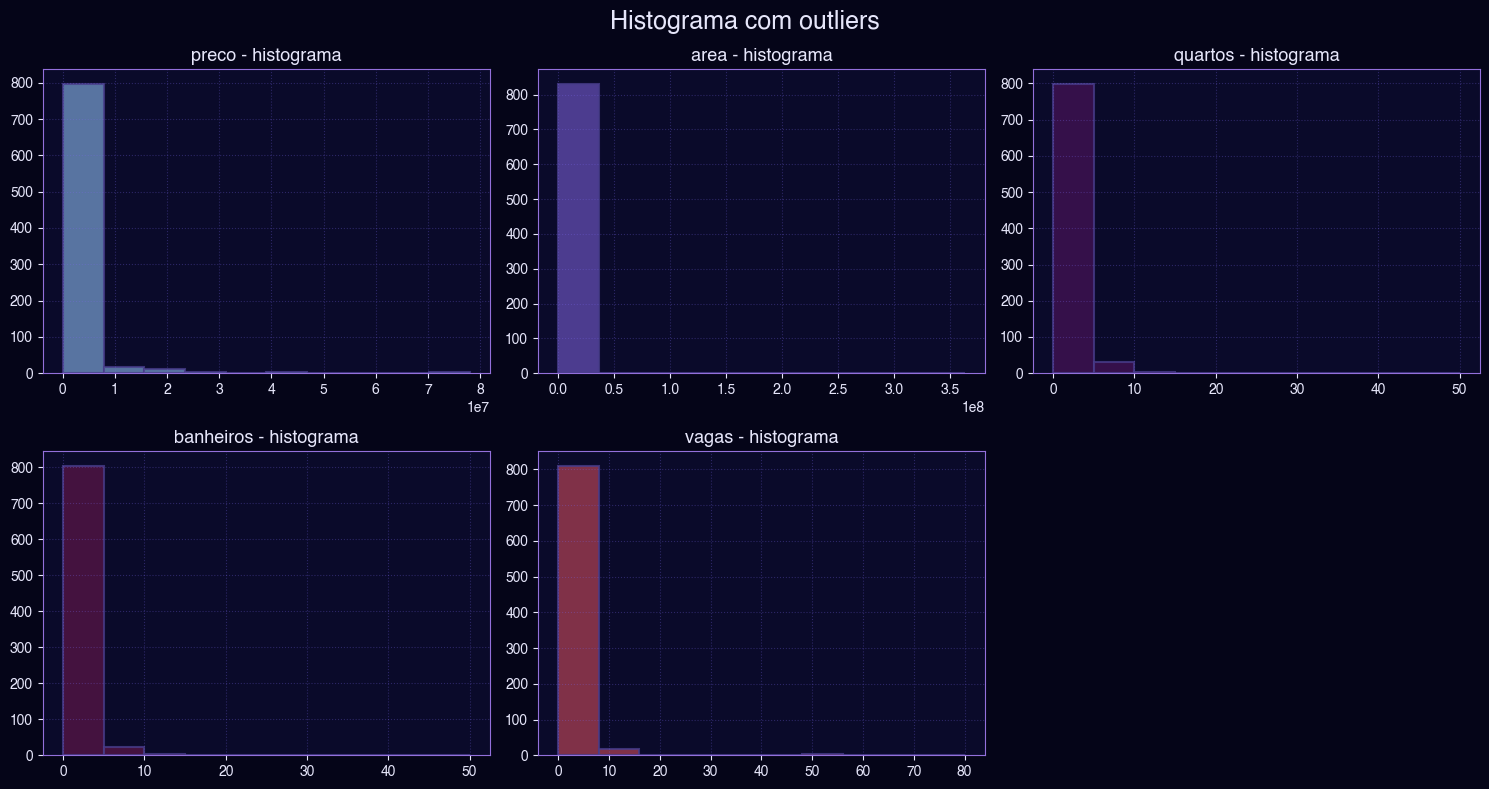

In [279]:
tipos = ["histograma"]*len(colunas)
dataframes = [df, df, df, df, df]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Histograma com outliers")

### **Boxplots com outliers**

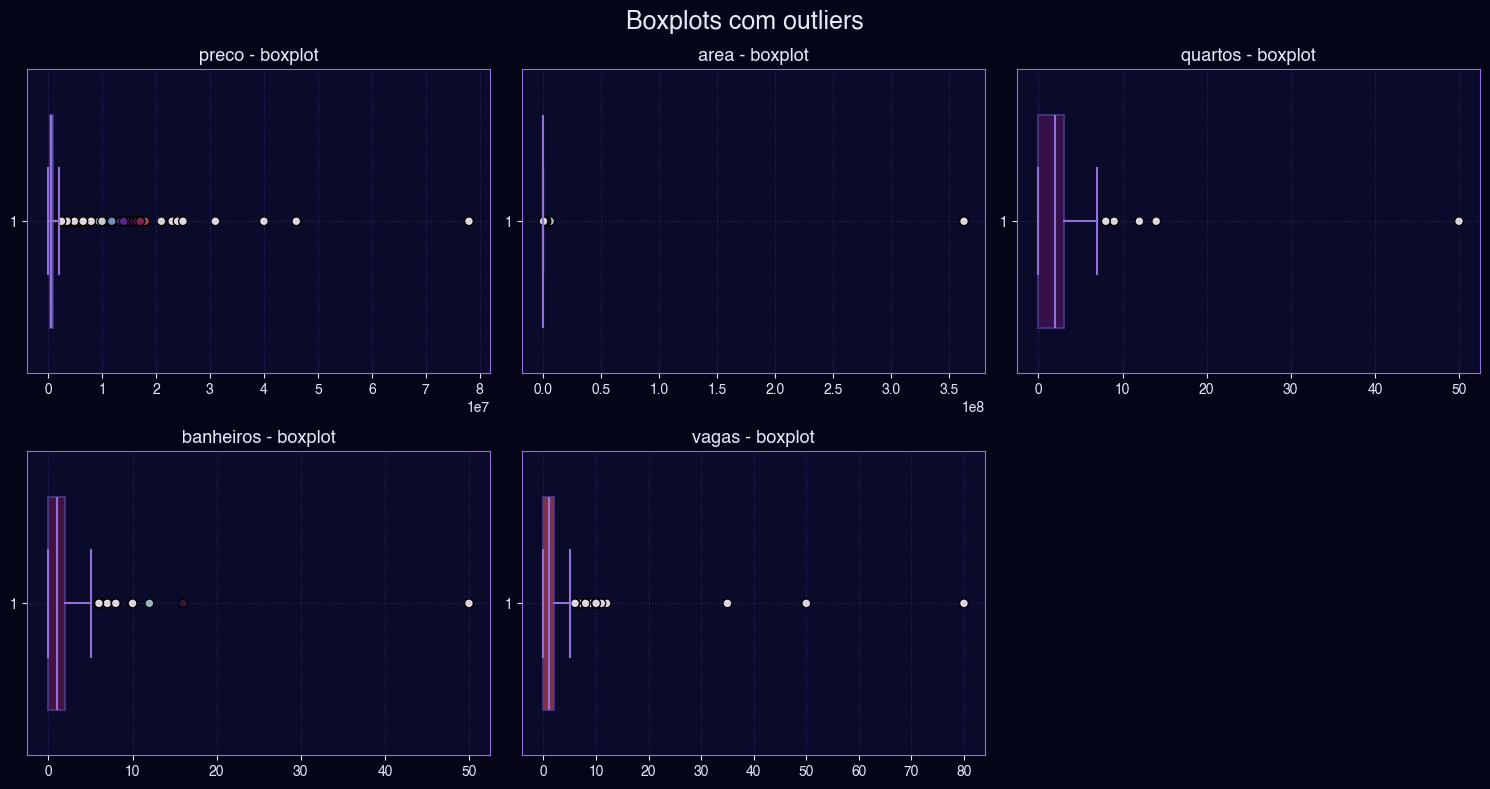

In [280]:
tipos = ["boxplot"]*len(colunas)
dataframes = [df, df, df, df, df]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Boxplots com outliers")

## **Remoção de Outliers**

In [281]:
# removendo outliers por limites personalizados (OPÇÃO 1)
df_sem_outliers = remover_outliers(df)
# removendo outliers por quantis (definir limite inferior e superior - OPÇÃO 2)
#df_sem_outliers = remover_outliers_quantis(df, colunas=cols)

### **Salvando dados sem outliers para arquivo .csv na camada thrusted**

In [282]:
caminho_thrusted = os.path.join(BASE_DIR, 'dados', 'thrusted', 'imoveis_sem_outliers.csv')
df_sem_outliers.to_csv(caminho_thrusted, index=False)

### **Correlação**

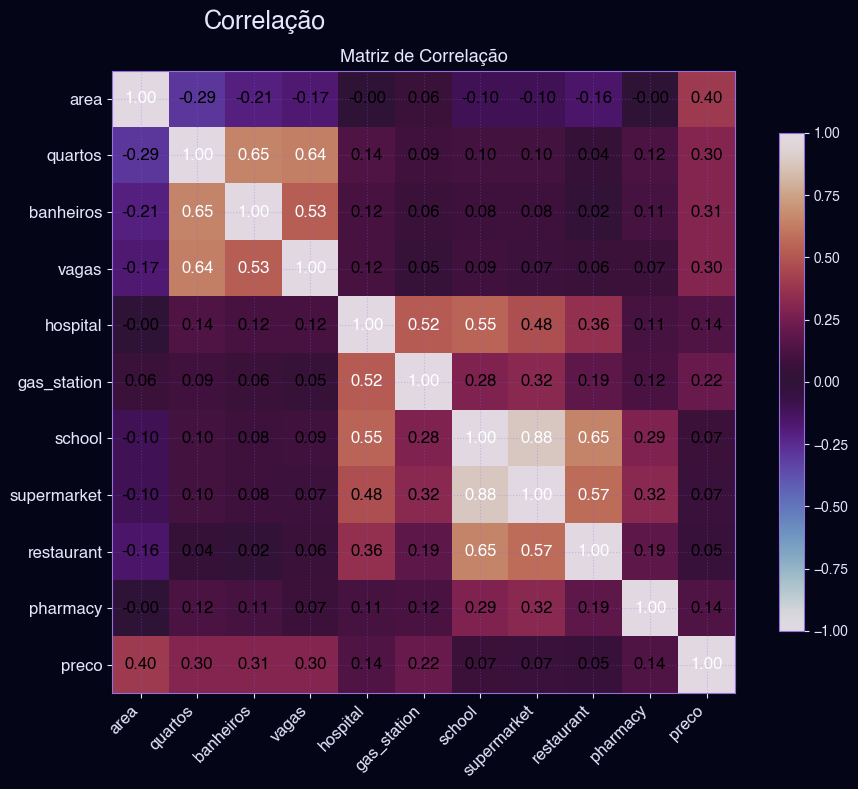

In [283]:
tipos = ["correlacao"]
dataframes = [df_sem_outliers]
gerar_graficos(dataframes, tipos, tema, colunas=[""], titulo_geral="Correlação")

### **Boxplot sem outliers**

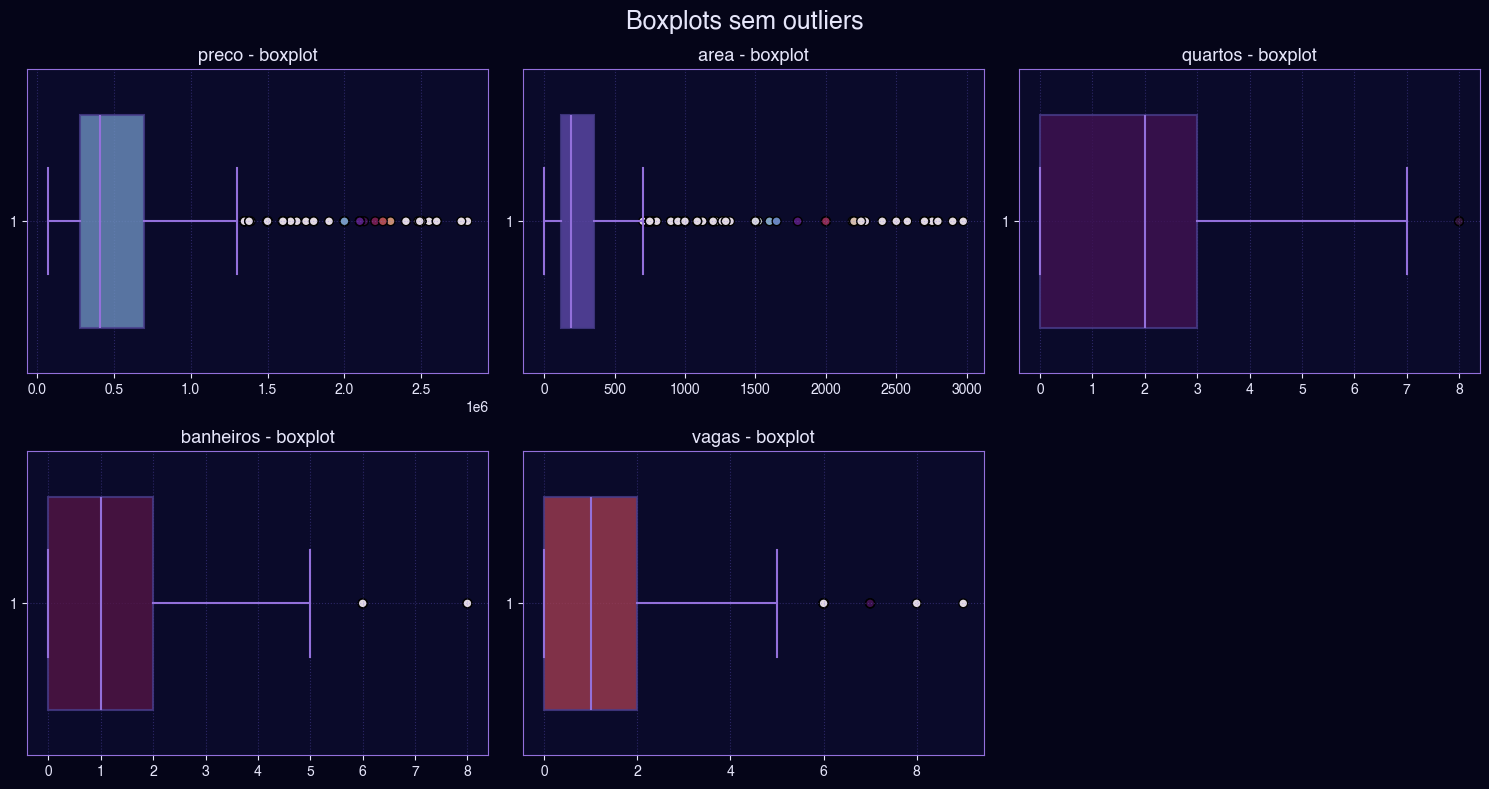

In [284]:
tipos = ["boxplot"]*len(colunas)
dataframes = [df_sem_outliers, df_sem_outliers, df_sem_outliers, df_sem_outliers, df_sem_outliers]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Boxplots sem outliers")

### **Histogramas sem outliers**

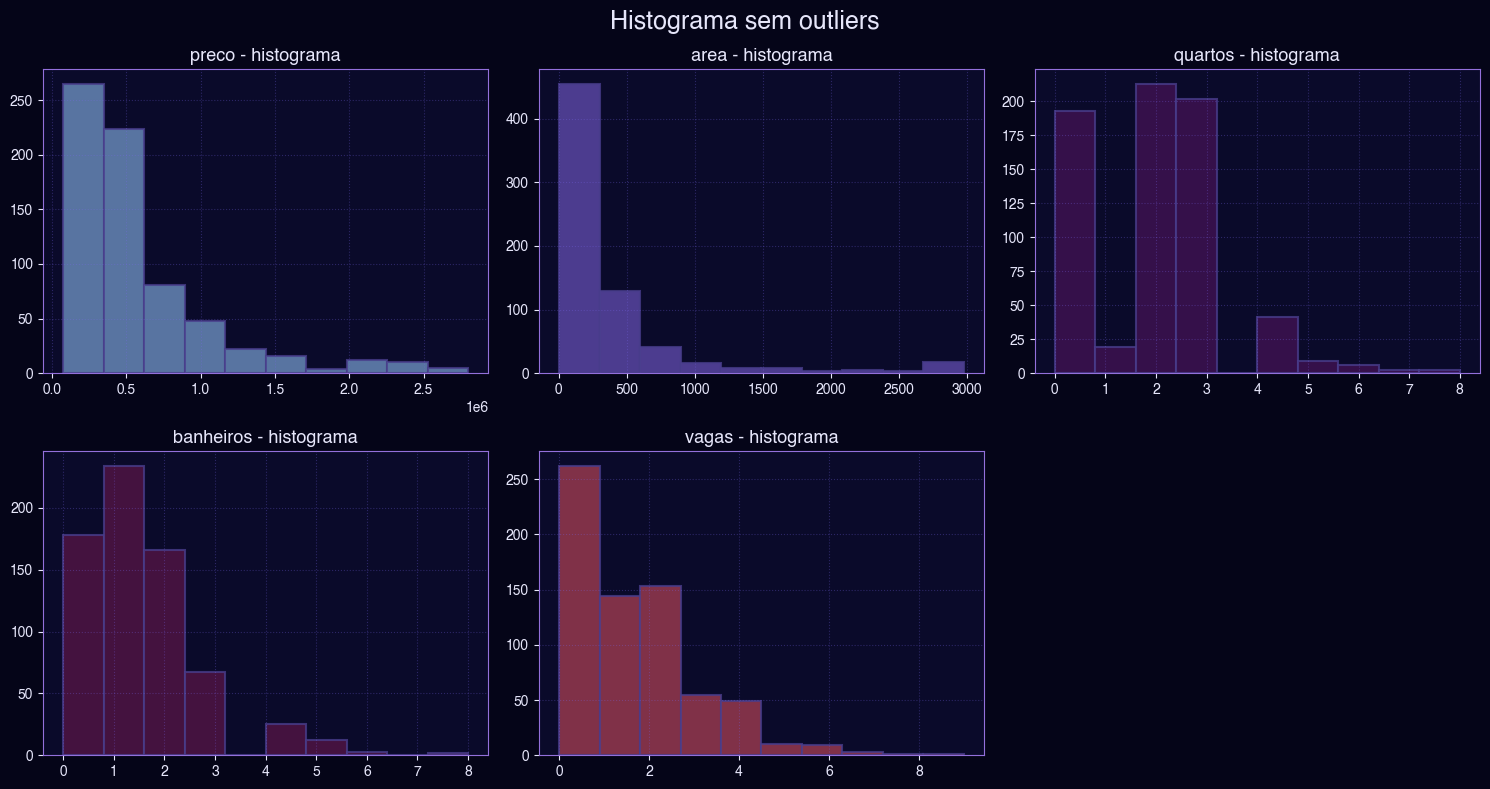

In [285]:
tipos = ["histograma"]*len(colunas)
dataframes = [df_sem_outliers, df_sem_outliers, df_sem_outliers, df_sem_outliers, df_sem_outliers]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Histograma sem outliers")

## **Métricas Importantes**

### **Bairros com Mais Imóveis Anunciados – Lorena/SP**

In [286]:
# Contagem de imóveis por bairro
contagem_bairros = (
    df_sem_outliers
    .groupby('bairro')['bairro']
    .count()
    .reset_index(name='quantidade_imoveis')
)

# Ordena os bairros mais anunciados
contagem_bairros = contagem_bairros.sort_values(by='quantidade_imoveis', ascending=False).head(20)

# Exibe os 10 bairros com mais imóveis
print(contagem_bairros)

colunas = [["bairro", "quantidade_imoveis"]]
tipos = ["barras"]

                              bairro  quantidade_imoveis
1                     Bairro da Cruz                 186
4                             Centro                  77
5                  Cidade Industrial                  69
21                        Vila Nunes                  46
12                   Parque Mondesir                  38
22                       Vila Passos                  30
11                            Olaria                  28
9   Loteamento Village das Palmeiras                  24
20                     Vila Hepacare                  23
19                         Vila Geny                  20
17                     Santo Antônio                  20
10                       Nova Lorena                  18
0                           Aterrado                  17
8        Loteamento Jardim Primavera                  16
24                Vila Santa Edwiges                  11
13               Parque das Rodovias                  10
25                    Vila São 

### **Bairros com Mais Imóveis Anunciados – Lorena/SP**

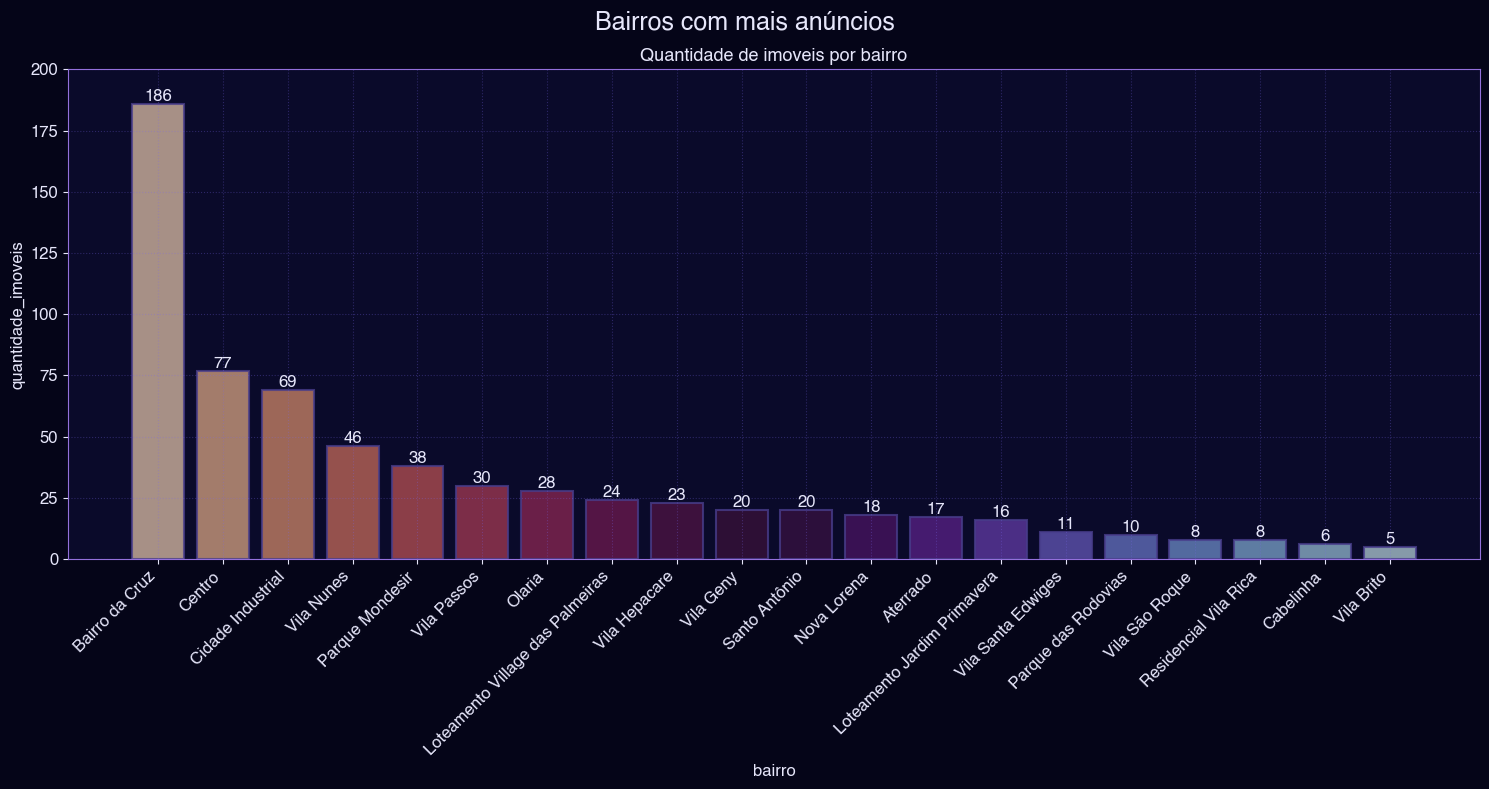

In [287]:
dataframes = [contagem_bairros]
colunas = [["bairro", "quantidade_imoveis"]]
tipos = ["barras"]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Bairros com mais anúncios")

### **Filtro para Imóveis residenciais - Lorena/SP**

In [288]:
# Filtro para pegar os bairros da área residencial da cidade de Lorena/SP
df_residencial = df_sem_outliers[
    (df_sem_outliers['quartos'] >= 1) &
    (df_sem_outliers['banheiros'] >= 1) & 
    (df_sem_outliers['vagas'] >= 1) & 
    (df_sem_outliers['bairro'] != "Área Rural de Lorena") &
    (df_sem_outliers['bairro'] != "Vila Portugal") &
    (df_sem_outliers['bairro'] != "Ponte Nova")
].copy()

### **Preço Médio de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

In [289]:
# cálculo do valor médio dos imóveis nos bairros residenciais de Lorena/SP, por bairro, top 10
preco_medio_por_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['preco']
    .mean()
    .astype({'preco': int})  # Converte a média para inteiro
    .sort_values(by='preco', ascending=False)
    .head(20)
)

print(preco_medio_por_bairro)

                              bairro    preco
6                   Jardim Margarida  1100000
1                     Bairro da Cruz   887289
4                             Centro   821102
8   Loteamento Village das Palmeiras   807457
11                   Parque Mondesir   669823
2                          Cabelinha   533800
17                         Vila Geny   531000
9                        Nova Lorena   500357
19                        Vila Nunes   482281
10                            Olaria   476000
18                     Vila Hepacare   446588
3                              Cecap   440000
5                  Cidade Industrial   438811
22                    Vila São Roque   409142
21                Vila Santa Edwiges   392375
16                        Vila Brito   389500
20                       Vila Passos   359826
15                     Santo Antônio   355999
14             Residencial Vila Rica   331800
23           Vila dos Comerciários I   316000


### **Preço Médio de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

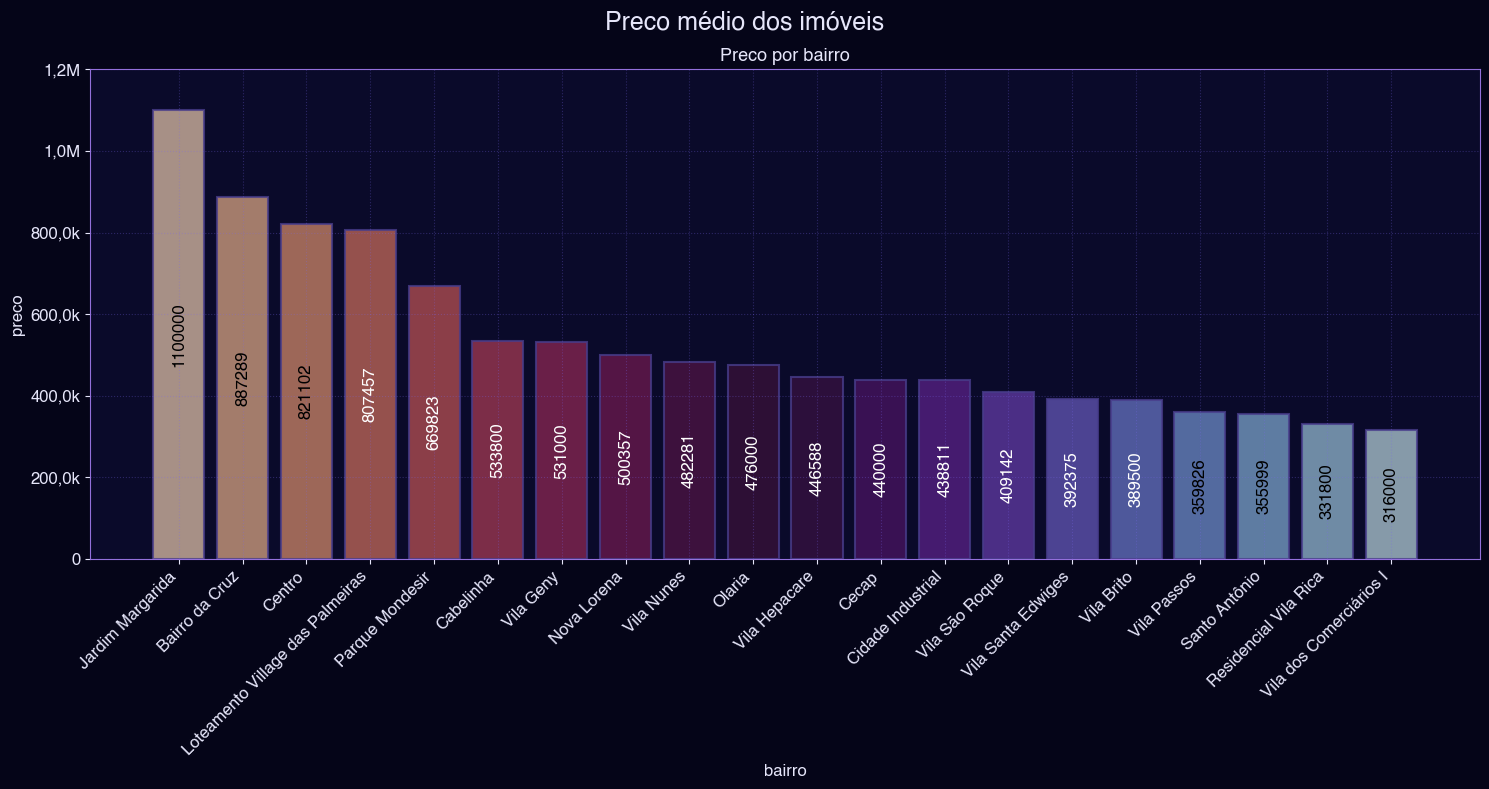

In [290]:
dataframes = [preco_medio_por_bairro]
colunas = [["bairro", "preco"]]
tipos = ["barras"]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Preco médio dos imóveis")

### **Área média de imóveis residenciais - Top 20 bairros, Lorena/SP**

In [291]:
# cálculo do valor médio dos imóveis nos bairros residenciais de Lorena/SP, por bairro, top 10
media_area_por_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['area']
    .mean()
    .astype({'area': int})  # Converte a média para inteiro
    .sort_values(by='area', ascending=False)
    .head(20)
)

print(media_area_por_bairro)

                              bairro  area
6                   Jardim Margarida   465
16                        Vila Brito   330
4                             Centro   301
1                     Bairro da Cruz   296
11                   Parque Mondesir   259
19                        Vila Nunes   171
0                           Aterrado   171
2                          Cabelinha   163
10                            Olaria   159
22                    Vila São Roque   159
8   Loteamento Village das Palmeiras   159
23           Vila dos Comerciários I   158
9                        Nova Lorena   153
17                         Vila Geny   144
5                  Cidade Industrial   140
18                     Vila Hepacare   130
20                       Vila Passos   130
15                     Santo Antônio   120
21                Vila Santa Edwiges   115
14             Residencial Vila Rica   102


### **Gráfico - Área Média de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

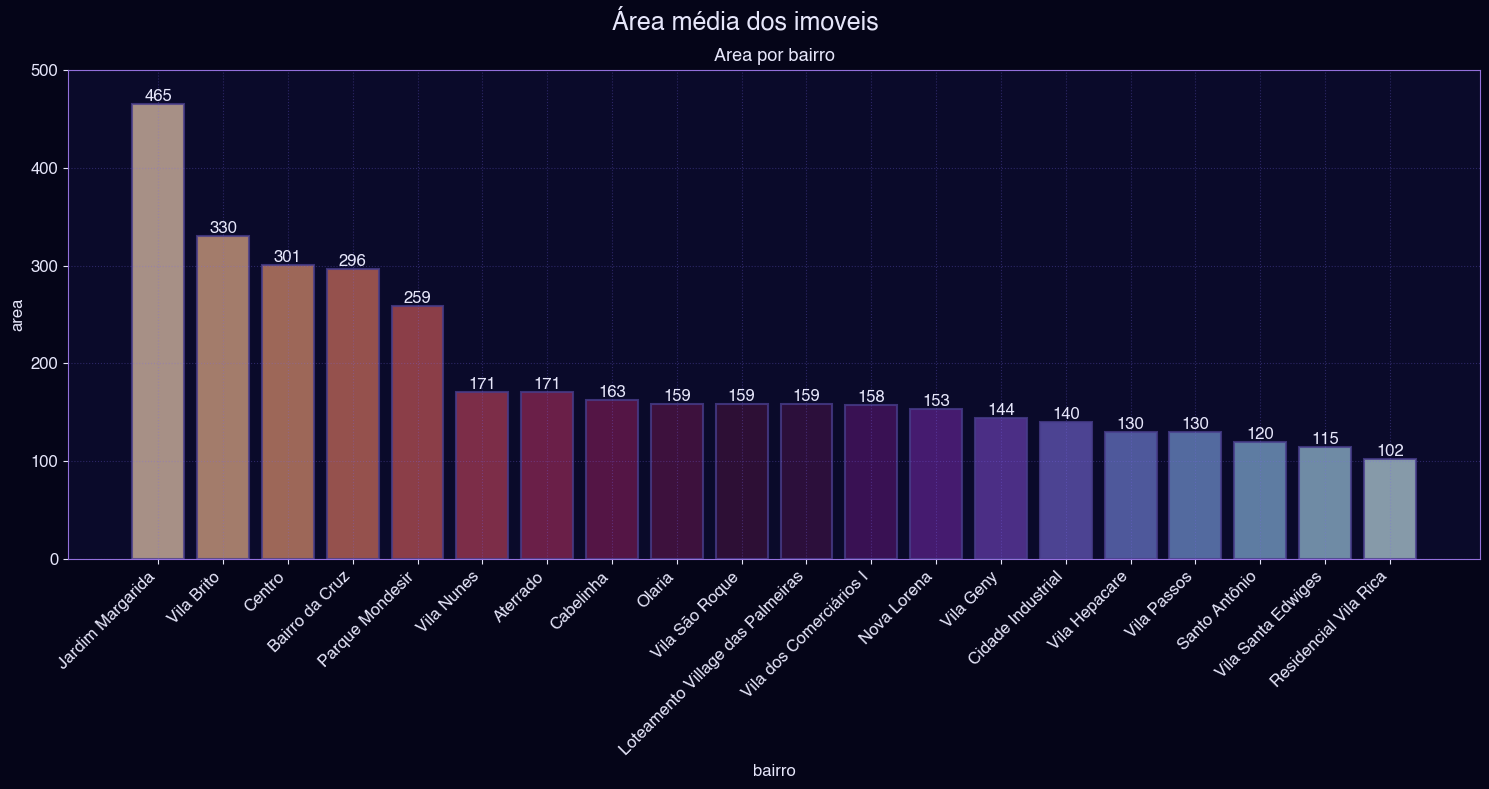

In [292]:
dataframes = [media_area_por_bairro]
colunas = [["bairro", "area"]]
tipos = ["barras"]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Área média dos imoveis")

### **Valor médio do m² residencial por bairro, Lorena/SP (TOP 20)**

In [293]:
df_residencial['preco_m2'] = (df_residencial['preco'] / df_residencial['area']).round(2)
# Média do preço por m²
media_m2_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['preco_m2']
    .mean().round(2)
    .sort_values(by='preco_m2', ascending=False)
    .head(10)
)
print(media_m2_bairro)

                              bairro  preco_m2
5                  Cidade Industrial  36417.59
22                    Vila São Roque   7565.05
7        Loteamento Jardim Primavera   6361.25
8   Loteamento Village das Palmeiras   5229.74
3                              Cecap   4717.50
19                        Vila Nunes   4702.37
12               Parque das Rodovias   4304.45
17                         Vila Geny   4264.46
1                     Bairro da Cruz   4008.41
0                           Aterrado   3921.13


### **Gráfico - Valor médio do m² por bairro, Lorena/SP (TOP 20)**

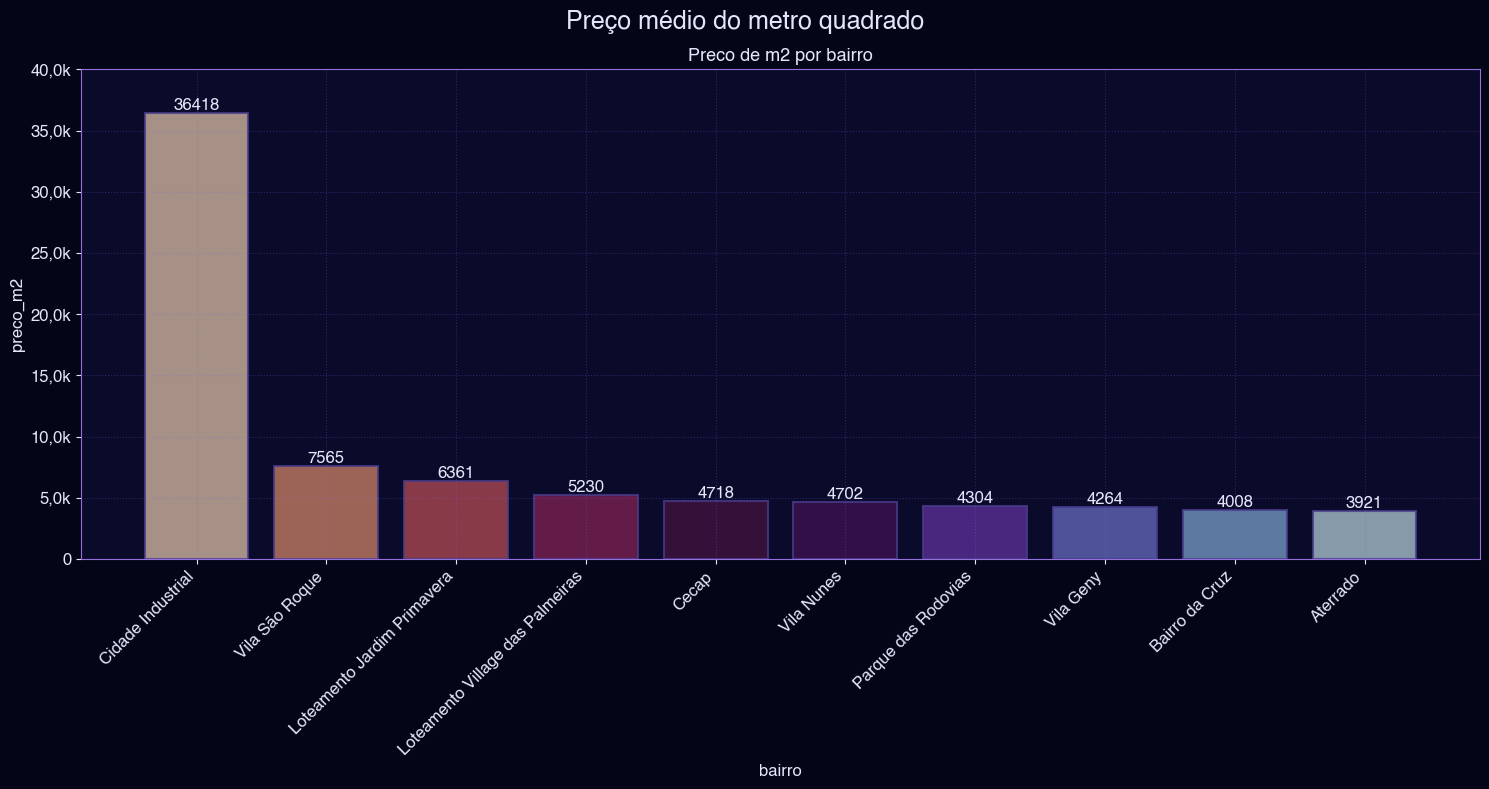

In [294]:
dataframes = [media_m2_bairro]
colunas = [["bairro", "preco_m2"]]
tipos = ["barras"]
gerar_graficos(dataframes, tipos, tema, colunas, titulo_geral="Preço médio do metro quadrado")